# Corrective RAG (CRAG) using local LLMs

[Corrective-RAG (CRAG)](https://arxiv.org/abs/2401.15884) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. 

The paper follows this general flow:

* If at least one document exceeds the threshold for `relevance`, then it proceeds to generation
* If all documents fall below the `relevance` threshold or if the grader is unsure, then it uses web search to supplement retrieval
* Before generation, it performs knowledge refinement of the search or retrieved documents
* This partitions the document into `knowledge strips`
* It grades each strip, and filters out irrelevant ones

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/):

* If *any* documents are irrelevant, we'll supplement retrieval with web search. 
* We'll skip the knowledge refinement, but this can be added back as a node if desired. 
* We'll use [Tavily Search](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

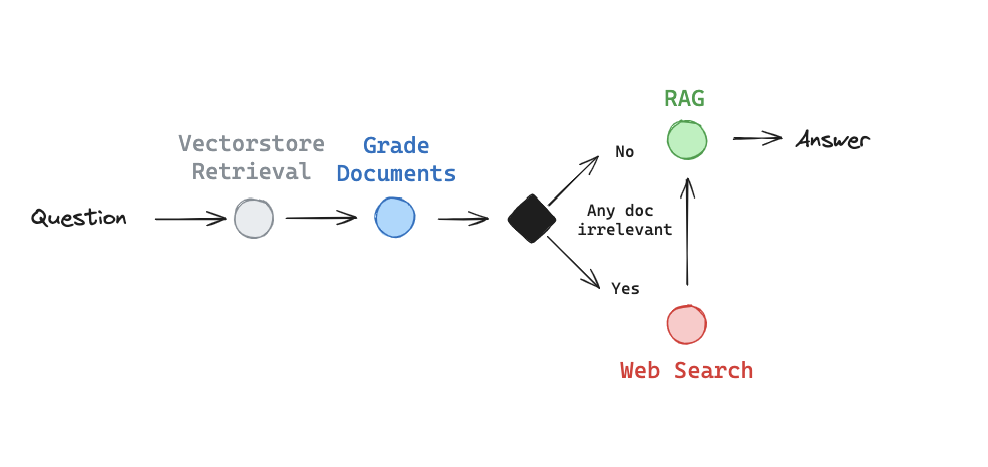

## Setup

We'll use [Ollama](https://ollama.ai/) to access a local LLM:

* Download [Ollama app](https://ollama.ai/).
* Pull your model of choice, e.g.: `ollama pull llama3`

We'll use [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) for web search.

We'll use a vectorstore with [Nomic local embeddings](https://blog.nomic.ai/posts/nomic-embed-text-v1) or, optionally, OpenAI embeddings.


Let's install our required packages and set our API keys:

In [1]:
# %%capture --no-stderr
# %pip install -U langchain_community tiktoken langchainhub scikit-learn langchain langgraph tavily-python  nomic[local] langchain-nomic langchain_openai

In [2]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

### LLM

You can select from [Ollama LLMs](https://ollama.com/library).

In [3]:
model = "qwen3:4b"

local_llm = "qwen3:4b"
model_tested = "qwen3:4b"
metadata = f"CRAG, {model_tested}"

## Create Index

Let's index 3 blog posts.

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_ollama import OllamaEmbeddings
from langchain_openai import OpenAIEmbeddings  # api

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Embedding
embedding = OllamaEmbeddings(model="nomic-embed-text", base_url="http://localhost:11434")


# Add the document chunks to the "vector store"
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Define Tools

In [5]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

C:\Users\laxmi\AppData\Local\Temp\ipykernel_41748\2568947859.py:8: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model=local_llm, format="json", temperature=0)


{'score': 1}


In [6]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

<think>
Okay, so the user is asking about "agent memory." Let me look through the provided documents to find relevant information.

The first document mentions that in an LLM-powered autonomous agent system, there's a section on Memory. It differentiates between short-term and long-term memory. Short-term memory is related to in-context learning, like Prompt Engineering. Long-term memory allows the agent to retain and recall information over extended periods using an external vector store and fast retrieval. 

Another document talks about memory streams as a long-term module that records agents' experiences in natural language. There's also a part about sensory memory, short-term memory being in-context learning with a finite context window, and long-term memory as an external vector store. 

So putting this together, agent memory in these contexts refers to both short-term (temporary, context-based) and long-term (persistent, external storage) components. The answer should mention bot

In [7]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## Create the Graph 

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

In [8]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

graph = workflow.compile()

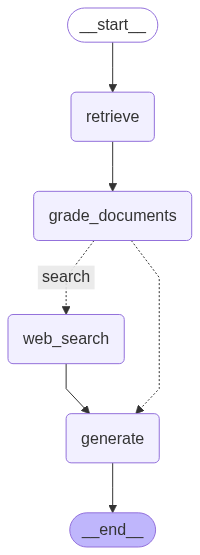

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from langchain_core.messages import HumanMessage
from pprint import pprint

initial_state = {
    "question": "What is the revenue of facebook in 2024?",
    "generation": "",
    "search": "",
    "documents": [],
    "steps": [],
}

for output in graph.stream(initial_state):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        pprint(value, indent=4, width=120)
    pprint("\n------\n")

"Output from node 'retrieve':"
'----'
{   'documents': [   Document(metadata={'id': 'e688e22d-0560-491a-b532-7596a21e6d13', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past ac